# CRDM Descriptives and QC

Input: 
* CRDM behavioral file from Psychopy [sub-####_ses-crdm_task.csv]

Ouput: 
* CRDM EV file [sub-####_ses-crdm_EV.csv]
* CRDM Risk Choice Figure [sub-####_ses-crdm_plots-risk.png]
* CRDM Ambiguity Choice Figure [sub-####_ses-crdm_plots-amb.png]

In [1]:
import os
import os.path, sys
import numpy as np
import pandas as pd
from glob import glob
from math import sqrt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white", palette="muted")
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import simps, trapz
import warnings
warnings.filterwarnings("ignore")

Saving to: Z:/data/SDDM\derivatives/ev/sub-0000/crdm\sub-0000_ses-crdm_plots-risk.png


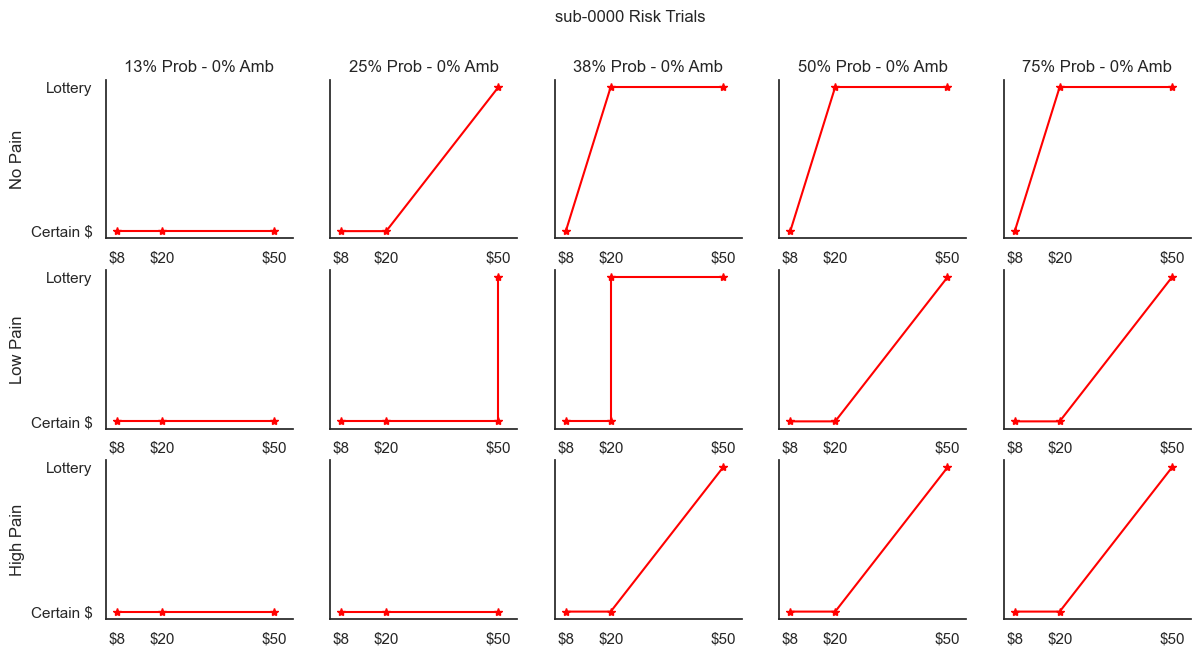

Saving to: Z:/data/SDDM\derivatives/ev/sub-0000/crdm\sub-0000_ses-crdm_plots-amb.png


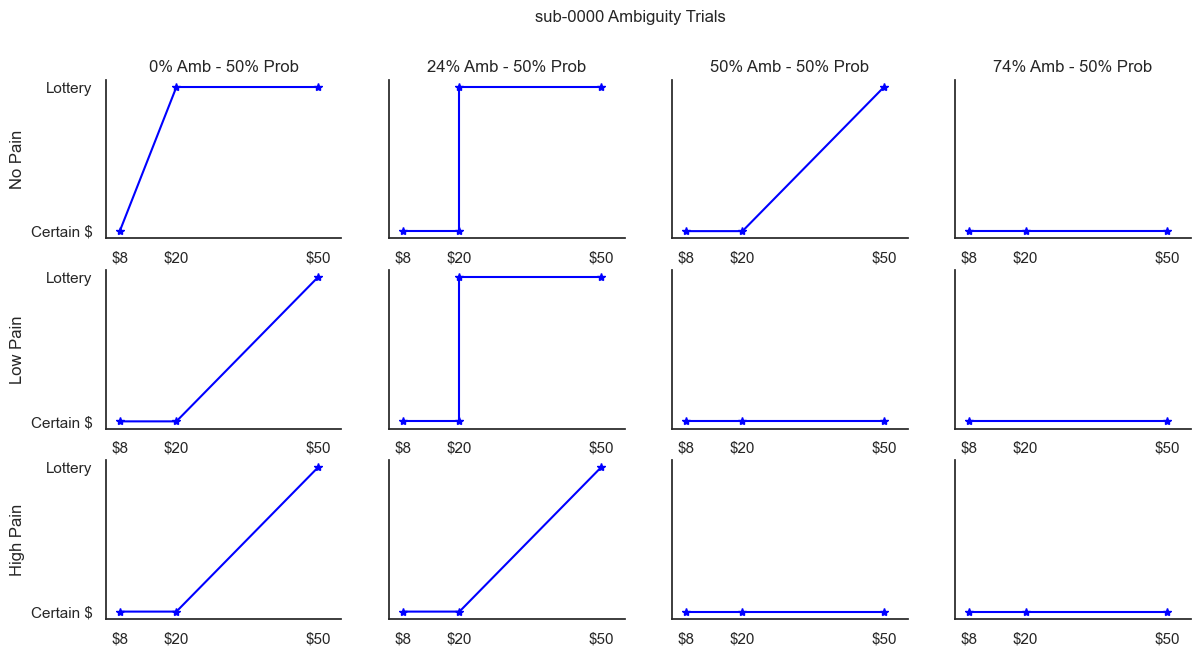

Saving to: Z:/data/SDDM\derivatives/ev/sub-0000/crdm\sub-0000_ses-crdm_ev.csv


In [2]:
base_proj_dir = "Z:/data/CCB" ## base project directory

subs = []
amb_levels = [0, 24, 50, 74]
prob_levels = [13, 25, 38, 50, 75]
pain_levels = [0, 1, 2]
pain_strs = ["no_pain", "low_pain", "high_pain"]
pain_labels = ["No Pain", "Low Pain", "High Pain"]
data_df = pd.DataFrame() ## need to think about data across Ss

prob_counts = {} ## across subjects counts for risk trials
amb_counts = {} ## across subjects counts for ambiguity trials

sub_files = sorted(glob(os.path.join(base_proj_dir, "sourcedata/behav/*/crdm/*crdm_task.csv"))) ## grab all CRDM task csvs files in folder -- will change pathes later to BIDS format
for i, curr_file in enumerate(sub_files): ## go through each subject file
    subs.append(os.path.basename(sub_files[0])[4:8]) ## append current subject ID to subs list
    fig1 = plt.figure(i, figsize=(14,7)) ## create Ss figure

    sub_cols = ["onset", "duration", "pain", "prob", "amb", "sure_amt", "lott_amt", "choice", "pain_rating"] ## trial variables to be saved to output file
    sub_df = pd.DataFrame(columns = sub_cols) ## subject-specific dataframe   
    raw_df = pd.read_csv(curr_file) ## import Ss behav file into Panda's dataframepd.read_csv(curr_file) #import Ss behav file into Panda's dataframe
    resp_df = raw_df.loc[(raw_df["crdm_trial_type"] == "task") & (raw_df["crdm_choice"].notnull())] ## only task trials with responses
    nonresp_df = raw_df.loc[(raw_df["crdm_trial_type"] == "task") & (raw_df["crdm_choice"].isnull()) & (raw_df["crdm_trial_img.started"].notnull())] ## only task trials with nonresponses (important for creating EV file)

    for j, this_pain in enumerate(pain_strs): ## calculates and saves probability trial count info for response and nonresponse trials
        for k, this_prob in enumerate(prob_levels):
            for l, this_choice in enumerate(["safe", "lott"]):
                prob_counts["{0}_{1}p_0a_{2}".format(this_pain, this_prob, this_choice)] = len(resp_df.loc[(resp_df["temp_lev"] == j) & (resp_df["crdm_lott_p"] == this_prob) 
                                                                                                        & (resp_df["crdm_amb_lev"] == 0) & (resp_df["crdm_choice"] == l)])
            prob_counts["{0}_{1}p_0a_nr".format(this_pain, this_prob)] = len(nonresp_df.loc[(nonresp_df["temp_lev"] == j) & (nonresp_df["crdm_lott_p"] == this_prob) & (nonresp_df["crdm_amb_lev"] == 0)])

        for k, this_amb in enumerate(amb_levels): ## calculates and saves ambiguity trial count info for response and nonresponse trials
            for l, this_choice in enumerate(["safe", "lott"]):
                amb_counts["{0}_50p_{2}a_{3}".format(this_pain, this_prob, this_amb, this_choice)] = len(resp_df.loc[(resp_df["temp_lev"] == j) & (resp_df["crdm_lott_p"] == 50) 
                                                                                                                    & (resp_df["crdm_amb_lev"] == this_amb) & (resp_df["crdm_choice"] == l)])
            amb_counts["{0}_50p_{1}a_nr".format(this_pain, this_amb)] = len(nonresp_df.loc[(nonresp_df["temp_lev"] == j) & (nonresp_df["crdm_lott_p"] == 50) & (nonresp_df["crdm_amb_lev"] == this_amb)])

    temp_df = pd.DataFrame() ## create fresh DF for each pain lev/prob combo
    temp_df['onset'] = resp_df['crdm_trial_img.started'] ## trial onset time
    temp_df['duration'] = [7] * len(temp_df['onset']) ## create column of trial durations (7 seconds per trial)
    temp_df['pain'] = resp_df['temp_lev'] ## trial level of pain (0 = no, 1 = low, 2 = high)
    temp_df['prob'] = resp_df['crdm_lott_p'] ## trial probability
    temp_df['amb'] = resp_df['crdm_amb_lev'] ## trial ambiguity
    temp_df['sure_amt'] = resp_df['crdm_sure_amt'] ## trial certain amount
    temp_df['lott_amt'] = resp_df['crdm_lott_top'] + resp_df['crdm_lott_bot'] ## trial lottery amount
    temp_df['choice'] = resp_df['crdm_choice'] ## trial choice (-1 = nonresponse, 0 = certain, 1 = lottery)
    temp_df['pain_rating'] = resp_df['crdm_pain_rating'] ## pain rating (0 = no pain, 1 - 9 low through high)
    temp_df = temp_df.astype(int) ## convert elements of dataframe to integers

    temp_df2 = pd.DataFrame() ## create separate DF for nonresponse task trials
    temp_df2["onset"] = nonresp_df["crdm_trial_img.started"] ## onset time of trial
    temp_df2["duration"] = [7] * len(temp_df2["onset"]) ## duration of trial (always 7 seconds)
    temp_df2["pain"] = nonresp_df["temp_lev"] ## temp of heat applied
    temp_df2["prob"] = nonresp_df["crdm_lott_p"] ## lottery probability
    temp_df2["amb"] = nonresp_df["crdm_amb_lev"] ## lottery ambiguity
    temp_df2["sure_amt"] = nonresp_df["crdm_sure_amt"] ## certain $ amount
    temp_df2["lott_amt"] = nonresp_df["crdm_lott_top"] + nonresp_df["crdm_lott_bot"] ## winning lottery amount
    temp_df2["choice"] = [-1] * len(temp_df2["onset"]) ## trial choice [all -1 to indicate nonresponse]
    pain_temp = nonresp_df["crdm_pain_rating"].tolist() ## convert to list type 
    pain_temp2 = []
    for this_trial in range(len(pain_temp)):
        if pain_temp[this_trial] != "[]": ## Ss responded on pain rating
            pain_temp2.append(int(pain_temp[this_trial])) ## append pain rating to pain_temp2 list
        else: ## Ss did not respond to pain rating
            pain_temp2.append(-1) ## append -1 to indicate nonresponse
    temp_df2["pain_rating"] = pain_temp2 ## (-1 = nonresponse, 0 = no pain, 1 - 9 low through high)
    temp_df2 = temp_df2.astype(int) ## convert all elements of dataframe to integers


    ##### PROBABILITY TRIALS #####
    for pain_idx, curr_pain in enumerate(pain_levels): ## 3 pain levels
        for prob_idx, curr_prob in enumerate(prob_levels): ## 5 probability levels
            fig_loc1 = 1 + prob_idx + (5 * pain_idx) ## index for sub-plot location
            fig1.add_subplot(3, 5, fig_loc1) ## defining location of subfigure

            ## pain and probability specific dataframe (individual trials)
            curr_trials1 = temp_df.loc[(temp_df["prob"] == curr_prob) & (temp_df["amb"] == 0) & (temp_df["pain"] == curr_pain)] ## grab trials for current probability level
            sub_df = pd.concat([sub_df, curr_trials1], ignore_index=True) ## add to subject output file dataframe

            ## isolation of unique lottery/choice pairs 
            all_x = curr_trials1["lott_amt"].tolist() ## convert all lottery amounts series to list
            all_y = curr_trials1["choice"].tolist() ## convert all choices series to list
            amt_choice_combos = list(zip(all_x, all_y)) ## tuples of lottery/choices for all relevant trials
            unique_combos = sorted(list(set(amt_choice_combos))) ## only unique lottery/choice combos
            combo_ct = [amt_choice_combos.count(item) for item in unique_combos] ## number of trials for each element of unique_combos
            x, y = list(zip(*sorted(unique_combos))) ## unzip unique_combos

            plt.plot(x, y, '*-', color = "red") ## create current subplot
            plt.ylim([-0.05, 1.05]) ## buffer to extremes of y-axis
            plt.xlim([5, curr_trials1["lott_amt"].max() + 5]) ## buffer to extremes of x-axis
            #plt.yticks(np.arange(0, 1.1, 1)) ## binary y-ticks (0 = certain $5, 1 = lottery)
            sns.despine(top = True) ## remove ticks and upper/right sides of subplots
            plt.xticks([8, 20, 50], ["$8", "$20", "$50"]) ## manually set x-axis tick values | 3 lott values
            #plt.xticks([8, 25, 40, 50], ["$8", "$25", "$40", "$50"]) ## manually set x-axis tick values | 4 lott values
            if prob_idx == 0: ## only add y axis labels to far left subfigures (row)
                plt.yticks([0, 1], ["Certain $", "Lottery"])
                plt.ylabel(pain_labels[pain_idx], fontsize=12)
            else:
                plt.yticks([])
            if pain_idx == 0:
                plt.title(str(curr_prob) + "% Prob - 0% Amb", fontsize=12)
    plt.suptitle("sub-" + subs[i] + " Risk Trials", fontsize=12) #title for entire figure
    save_dir = os.path.join(base_proj_dir, "derivatives/ev/sub-{0}/crdm".format(subs[i])) #set Ss specific save directory
    if not os.path.exists(save_dir): #new Ss
        os.makedirs(save_dir) #make new Ss save directory
        print("---------------> NEW PARTICIPANT DIRECTORY CREATED: sub-{0}".format(subs[i])) #indicate new Ss directory was made
    fig_save = os.path.join(save_dir, "sub-{}_ses-crdm_plots-risk.png".format(subs[i])) #directory and filename for Risk plots
    print("Saving to: {}".format(fig_save)) #indicate Ss save directory
    plt.savefig(fig_save) #save Risk plots
    plt.show()


    ##### AMBIGUITY TRIALS #####
    fig2 = plt.figure(i, figsize=(14,7))
    for pain_idx, curr_pain in enumerate(pain_levels):
        for amb_idx, curr_amb in enumerate(amb_levels):
            fig2_loc = 1 + amb_idx + (4 * pain_idx)
            fig2.add_subplot(3, 4, fig2_loc)
            curr_trials2 = temp_df.loc[(temp_df["prob"] == 50) & (temp_df["amb"] == curr_amb) & (temp_df["pain"] == curr_pain)] 
            all_x = curr_trials2["lott_amt"].tolist() 
            all_y = curr_trials2["choice"].tolist() 
            amt_choice_combos = list(zip(all_x, all_y)) 
            unique_combos = list(set(amt_choice_combos)) 
            combo_ct = [amt_choice_combos.count(item) for item in unique_combos] 
            x, y = list(zip(*sorted(unique_combos)))
            curr_trials3 = curr_trials2.loc[(curr_trials2["amb"] != 0)] #used specifically to prevent duplication in EV output file
            sub_df = pd.concat([sub_df, curr_trials3], ignore_index=True) #add to Ss output file dataframe
            plt.plot(x, y, '*-', color = "blue")
            plt.ylim([-0.05, 1.05])
            plt.xlim([5, curr_trials2["lott_amt"].max() + 5])
            #plt.yticks(np.arange(0, 1.1, 1)) #binary y-ticks (0 = certain $5, 1 = lottery)
            sns.despine(top=True)
            plt.xticks([8, 20, 50], ["$8", "$20", "$50"])
            #plt.xticks([8, 25, 40, 50], ["$8", "$25", "$40", "$50"]) ## manually set x-axis tick values | 4 lott values
            #plt.xticks([0, 10, 20, 30, 40, 50], ["$0", "$10", "$20", "$30", "$40", "$50"])
            if amb_idx == 0:
                plt.yticks([0, 1], ["Certain $", "Lottery"])
                plt.ylabel(pain_labels[pain_idx], fontsize=12)
            else:
                plt.yticks([])
            if pain_idx == 0: 
                plt.title(str(curr_amb) + "% Amb - 50% Prob", fontsize=12)
    plt.suptitle("sub-" + subs[i] + " Ambiguity Trials", fontsize=12) 
    fig_save = os.path.join(save_dir, "sub-{}_ses-crdm_plots-amb.png".format(subs[i])) 
    print("Saving to: {}".format(fig_save)) 
    plt.savefig(fig_save) 
    plt.show() 

    sub_filename = os.path.join(save_dir, "sub-{}_ses-crdm_ev.csv".format(subs[i])) #path/filename to save EV file
    print("Saving to: {}".format(sub_filename)) #indicate Ss save directory
    sub_df.to_csv(sub_filename) #save EV file

prob_counts_df = pd.DataFrame(prob_counts, index = subs) #convert prob_counts dict to DF
amb_counts_df = pd.DataFrame(amb_counts, index = subs) #convert amb_counts dict to DF

# Choice Counts & Percentages

## Risky Trials

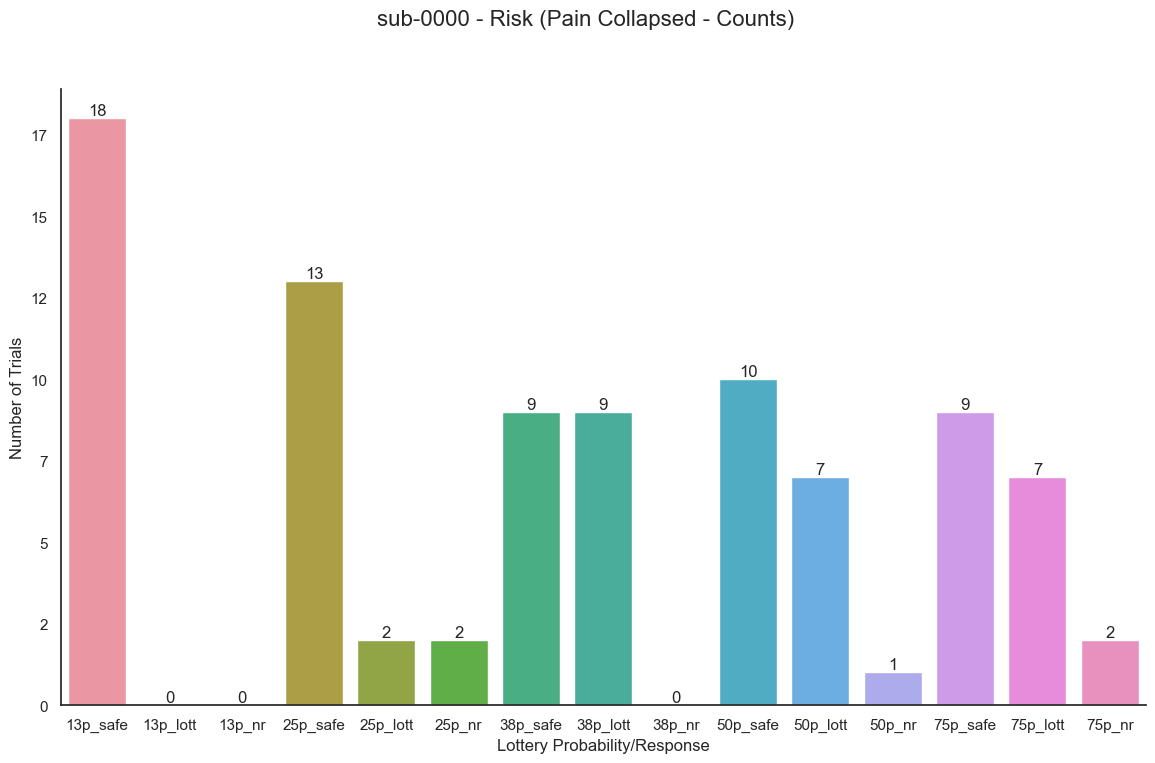

In [3]:
import matplotlib
matplotlib.axes.Axes.pie
matplotlib.pyplot.bar

agg_prob_df = pd.DataFrame()
labels = []
for x in ["13", "25", "38", "50", "75"]:
    for j in ["safe", "lott", "nr"]:
        agg_prob_df["{0}p_{1}".format(x, j)] = prob_counts_df["no_pain_{0}p_0a_{1}".format(x, j)] 
                                            + prob_counts_df["low_pain_{0}p_0a_{1}".format(x, j)] 
                                            + prob_counts_df["high_pain_{0}p_0a_{1}".format(x, j)]
        labels.append("Prob {0} {1}".format(x, j))
fig, ax = plt.subplots(figsize = (14,8))
sns.barplot(agg_prob_df)
ax.set_ylabel("Number of Trials")
ax.set_xlabel("Lottery Probability/Response")
sns.despine(top = True)
ax.set_yticklabels(ax.get_yticks().astype(int))
ax.bar_label(ax.containers[0])
plt.suptitle("sub-" + subs[i] + " - Risk (Pain Collapsed - Counts)", fontsize=16) 
plt.show()

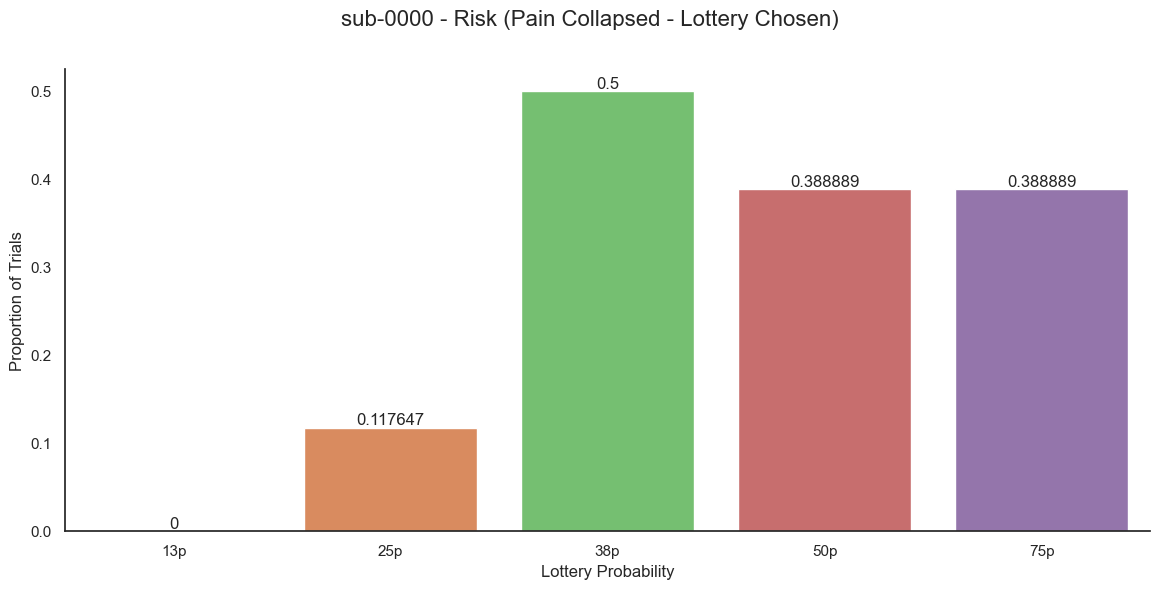

In [4]:
agg_prob_df1 = pd.DataFrame()

for x0 in ["13", "25", "38", "50", "75"]:
    agg_prob_df1["{0}p".format(x0)] = agg_prob_df["{0}p_lott".format(x0)] / (agg_prob_df["{0}p_lott".format(x0)] 
                                                                            + agg_prob_df["{0}p_safe".format(x0)] 
                                                                            + agg_prob_df["{0}p_nr".format(x0)])
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(agg_prob_df1)
ax.set_ylabel("Proportion of Trials")
sns.despine(top = True)
#ax.set_yticklabels(ax.get_yticks().astype(int))
ax.bar_label(ax.containers[0])
ax.set_xlabel("Lottery Probability")
plt.suptitle("sub-" + subs[i] + " - Risk (Pain Collapsed - Lottery Chosen)", fontsize=16) 
plt.show()

#### Risk Trials by Pain Level

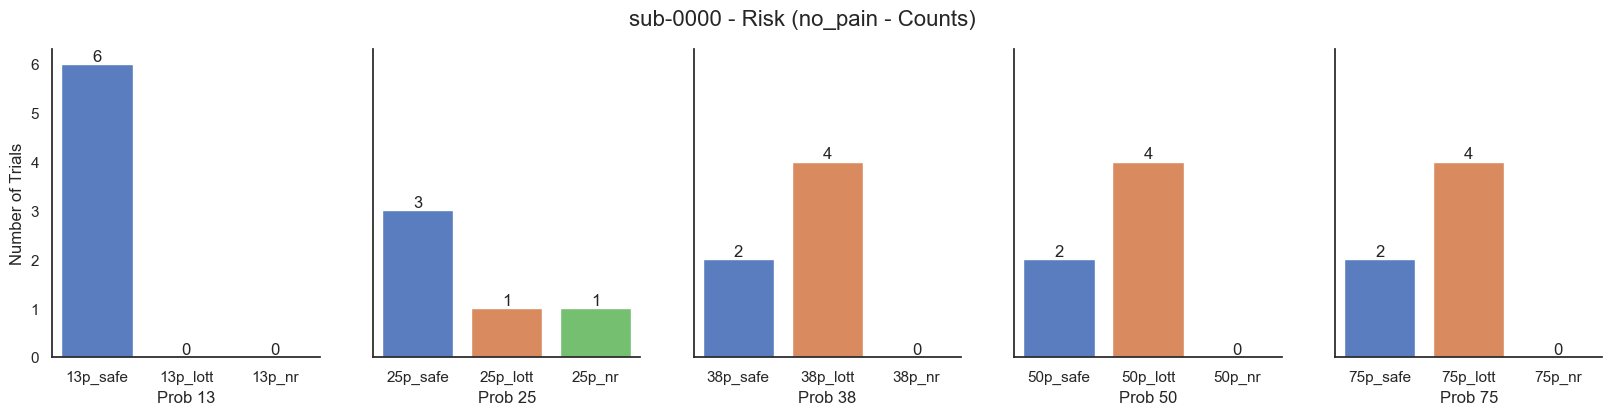

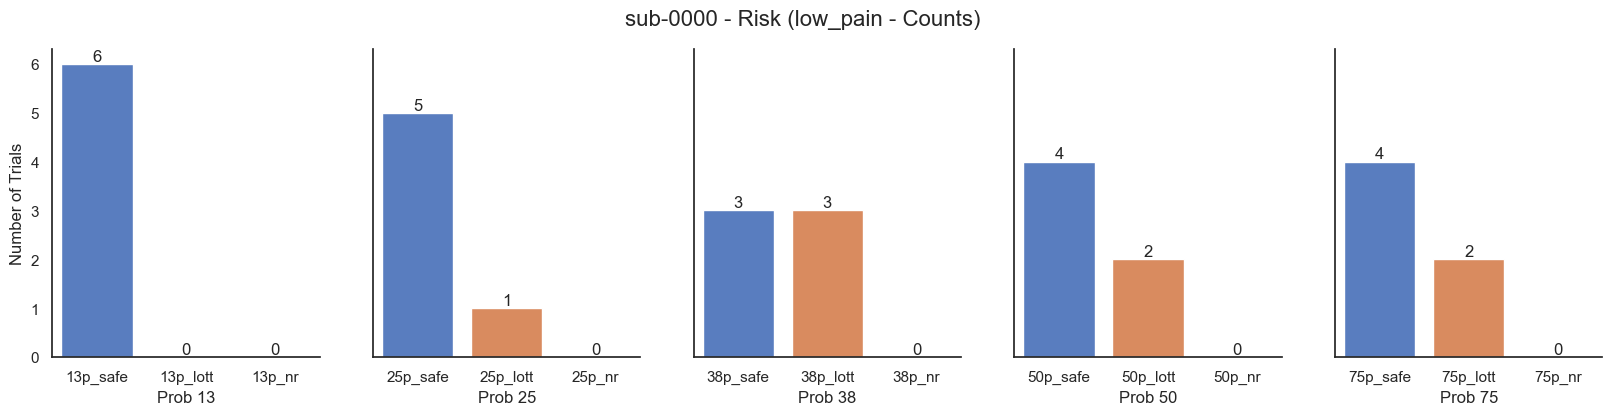

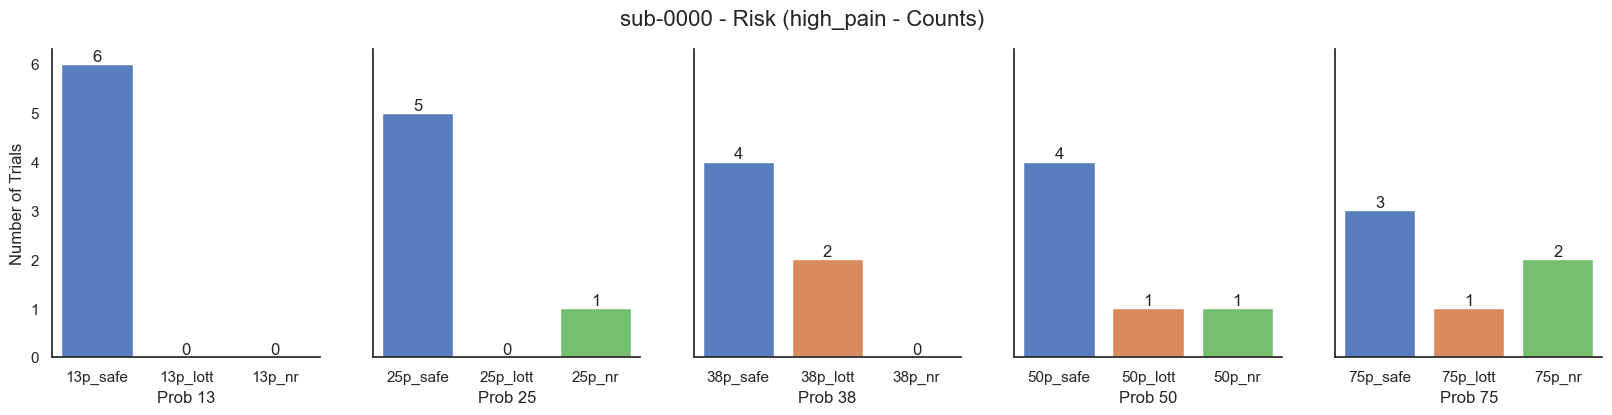

In [5]:
for x2 in ["no_pain", "low_pain", "high_pain"]:
    agg_prob_df2 = pd.DataFrame()
    for x3 in ["13", "25", "38", "50", "75"]:
        for x4 in ["safe", "lott", "nr"]:
            agg_prob_df2["{0}p_{1}".format(x3, x4)] = prob_counts_df["{0}_{1}p_0a_{2}".format(x2, x3, x4)]
    fig, axs = plt.subplots(ncols=5, figsize=(20,4), sharex=False, sharey=True)
    sns.despine(top=True)
    sns.barplot(agg_prob_df2[agg_prob_df2.columns[:3].tolist()], ax=axs[0])
    axs[0].bar_label(axs[0].containers[0])
    axs[0].set_xlabel("Prob 13")
    axs[0].set_ylabel("Number of Trials")
    sns.barplot(agg_prob_df2[agg_prob_df2.columns[3:6].tolist()], ax=axs[1])
    axs[1].bar_label(axs[1].containers[0])
    axs[1].set_xlabel("Prob 25")
    sns.barplot(agg_prob_df2[agg_prob_df2.columns[6:9].tolist()], ax=axs[2])
    axs[2].bar_label(axs[2].containers[0])
    axs[2].set_xlabel("Prob 38")
    sns.barplot(agg_prob_df2[agg_prob_df2.columns[9:12].tolist()], ax=axs[3])
    axs[3].bar_label(axs[3].containers[0])
    axs[3].set_xlabel("Prob 50")
    sns.barplot(agg_prob_df2[agg_prob_df2.columns[12:15].tolist()], ax=axs[4])
    axs[4].bar_label(axs[4].containers[0])
    axs[4].set_xlabel("Prob 75")
    plt.suptitle("sub-" + subs[i] + " - Risk ({0} - Counts)".format(x2), fontsize=16) 

Text(0.5, 0.98, 'sub-0000 - Risk (Lottery Chosen)')

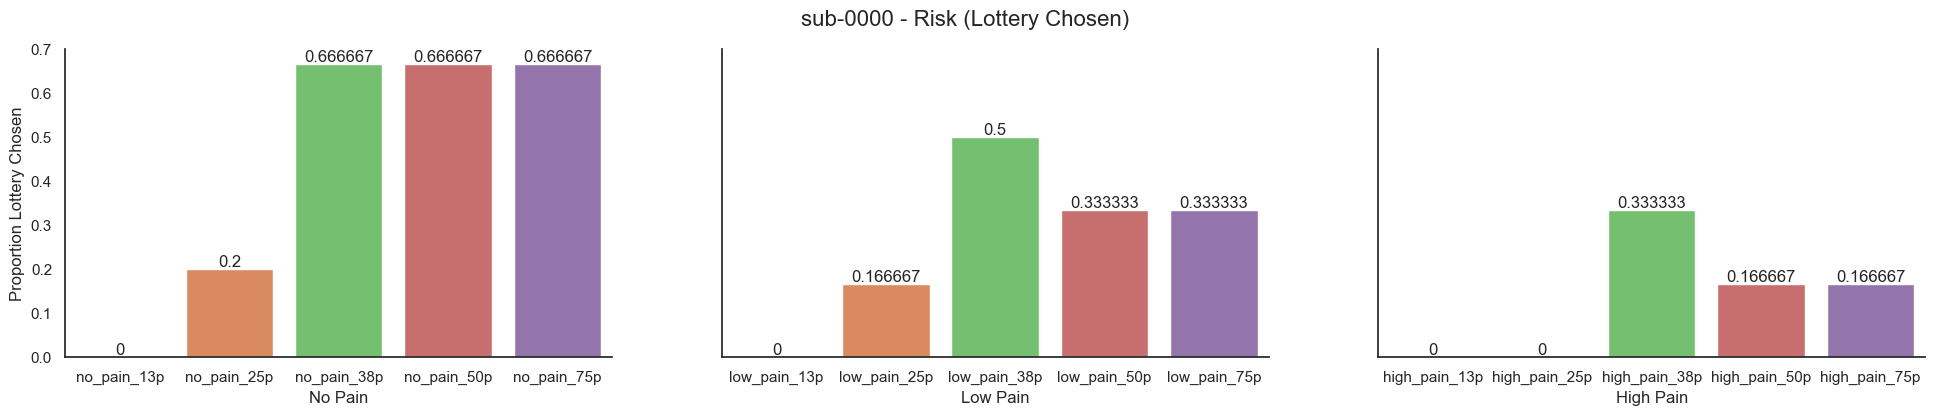

In [6]:
agg_prob_df3 = pd.DataFrame()
for x2 in ["no_pain", "low_pain", "high_pain"]:
    for x3 in ["13", "25", "38", "50", "75"]:
        agg_prob_df3["{0}_{1}p".format(x2, x3)] = prob_counts_df["{0}_{1}p_0a_lott".format(x2, x3)] / (prob_counts_df["{0}_{1}p_0a_lott".format(x2, x3)] 
                                                                                                        + prob_counts_df["{0}_{1}p_0a_safe".format(x2, x3)] 
                                                                                                        + prob_counts_df["{0}_{1}p_0a_nr".format(x2, x3)])
fig, axs = plt.subplots(ncols=3, figsize=(24,4), sharex=False, sharey=True)
sns.despine(top=True)
sns.barplot(agg_prob_df3[agg_prob_df3.columns[:5].tolist()], ax=axs[0])
axs[0].bar_label(axs[0].containers[0])
axs[0].set_xlabel("No Pain")
axs[0].set_ylabel("Proportion Lottery Chosen")
sns.barplot(agg_prob_df3[agg_prob_df3.columns[5:10].tolist()], ax=axs[1])
axs[1].bar_label(axs[1].containers[0])
axs[1].set_xlabel("Low Pain")
sns.barplot(agg_prob_df3[agg_prob_df3.columns[10:15].tolist()], ax=axs[2])
axs[2].bar_label(axs[2].containers[0])
axs[2].set_xlabel("High Pain")
plt.suptitle("sub-" + subs[i] + " - Risk (Lottery Chosen)", fontsize=16)

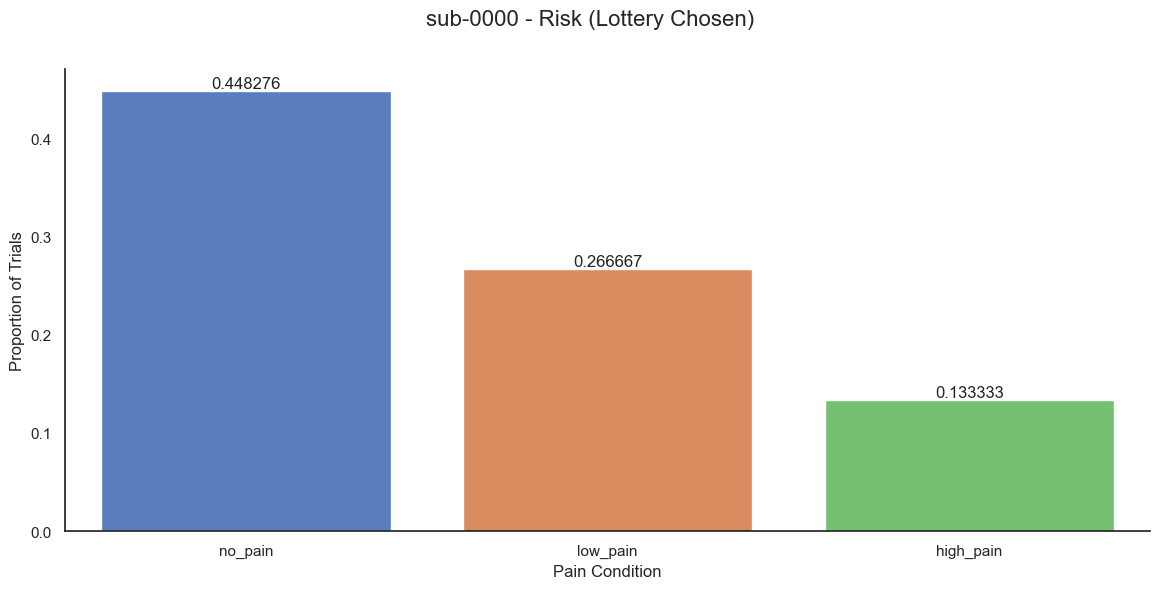

In [7]:
agg_prob_df4 = pd.DataFrame()

for a in ["no_pain", "low_pain", "high_pain"]:
    agg_prob_df4["{0}".format(a)] = (prob_counts_df["{0}_13p_0a_lott".format(a)] + prob_counts_df["{0}_25p_0a_lott".format(a)] + prob_counts_df["{0}_38p_0a_lott".format(a)] + prob_counts_df["{0}_50p_0a_lott".format(a)] 
                                    + prob_counts_df["{0}_75p_0a_lott".format(a)]) / (prob_counts_df["{0}_13p_0a_lott".format(a)] + prob_counts_df["{0}_25p_0a_lott".format(a)] + prob_counts_df["{0}_38p_0a_lott".format(a)] 
                                                                                    + prob_counts_df["{0}_50p_0a_lott".format(a)] + prob_counts_df["{0}_75p_0a_lott".format(a)] + prob_counts_df["{0}_13p_0a_safe".format(a)] 
                                                                                    + prob_counts_df["{0}_25p_0a_safe".format(a)] + prob_counts_df["{0}_38p_0a_safe".format(a)] + prob_counts_df["{0}_50p_0a_safe".format(a)] 
                                                                                    + prob_counts_df["{0}_75p_0a_safe".format(a)] + prob_counts_df["{0}_13p_0a_nr".format(a)] + prob_counts_df["{0}_25p_0a_nr".format(a)] 
                                                                                    + prob_counts_df["{0}_38p_0a_nr".format(a)] + prob_counts_df["{0}_50p_0a_nr".format(a)] + prob_counts_df["{0}_75p_0a_nr".format(a)])
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(agg_prob_df4)
ax.set_ylabel("Proportion of Trials")
sns.despine(top=True)
#ax.set_yticklabels(ax.get_yticks().astype(int))
ax.bar_label(ax.containers[0])
ax.set_xlabel("Pain Condition")
plt.suptitle("sub-" + subs[i] + " - Risk (Lottery Chosen)", fontsize=16) 
plt.show()    

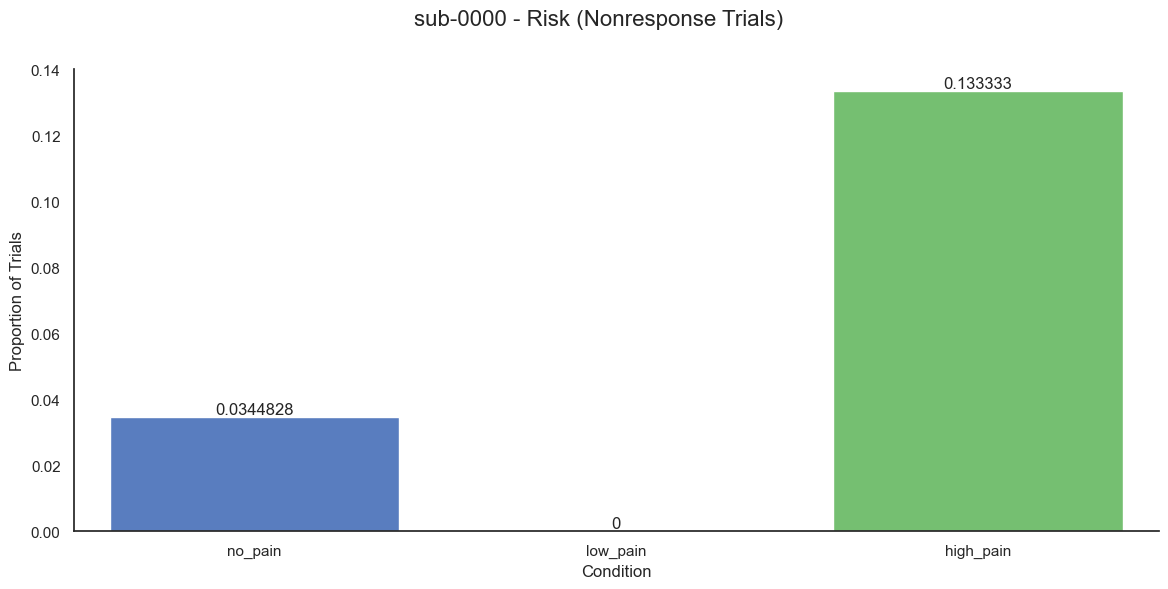

In [8]:
agg_prob_df5 = pd.DataFrame()

for this_pain in ["no_pain", "low_pain", "high_pain"]:
    agg_prob_df5["{0}".format(this_pain)] = (prob_counts_df["{0}_13p_0a_nr".format(this_pain)] + prob_counts_df["{0}_25p_0a_nr".format(this_pain)] 
                                            + prob_counts_df["{0}_38p_0a_nr".format(this_pain)] + prob_counts_df["{0}_50p_0a_nr".format(this_pain)] 
                                            + prob_counts_df["{0}_75p_0a_nr".format(this_pain)]) / (prob_counts_df["{0}_13p_0a_nr".format(this_pain)] 
                                                                                                    + prob_counts_df["{0}_25p_0a_nr".format(this_pain)] + prob_counts_df["{0}_38p_0a_nr".format(this_pain)] 
                                                                                                    + prob_counts_df["{0}_50p_0a_nr".format(this_pain)] + prob_counts_df["{0}_75p_0a_nr".format(this_pain)] 
                                                                                                    + prob_counts_df["{0}_13p_0a_safe".format(this_pain)] + prob_counts_df["{0}_25p_0a_safe".format(this_pain)] 
                                                                                                    + prob_counts_df["{0}_38p_0a_safe".format(this_pain)] + prob_counts_df["{0}_50p_0a_safe".format(this_pain)] 
                                                                                                    + prob_counts_df["{0}_75p_0a_safe".format(this_pain)] + prob_counts_df["{0}_13p_0a_lott".format(this_pain)] 
                                                                                                    + prob_counts_df["{0}_25p_0a_lott".format(this_pain)] + prob_counts_df["{0}_38p_0a_lott".format(this_pain)] 
                                                                                                    + prob_counts_df["{0}_50p_0a_lott".format(this_pain)] + prob_counts_df["{0}_75p_0a_lott".format(this_pain)])
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(agg_prob_df5)
ax.set_ylabel("Proportion of Trials")
sns.despine(top=True)
#ax.set_yticklabels(ax.get_yticks().astype(int))
ax.bar_label(ax.containers[0])
ax.set_xlabel("Condition")
plt.suptitle("sub-" + subs[i] + " - Risk (Nonresponse Trials)", fontsize=16) 
plt.show()

## Ambiguity Trials

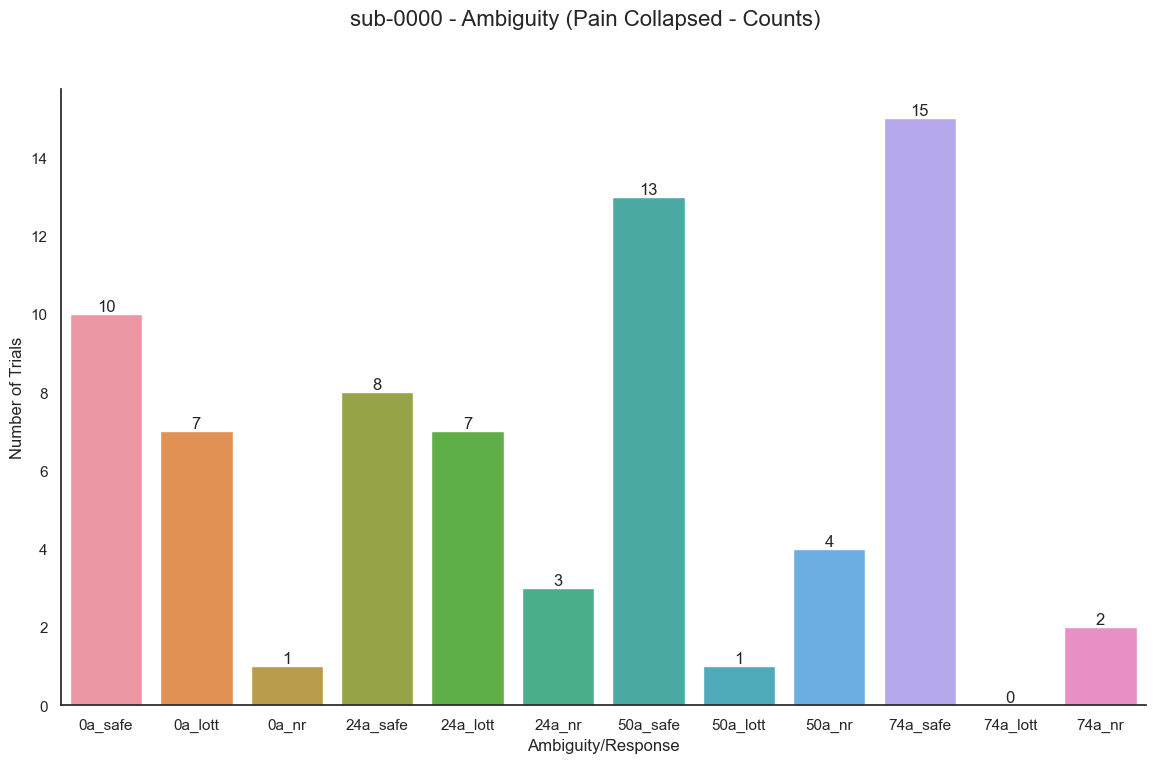

In [9]:
import matplotlib
matplotlib.axes.Axes.pie
matplotlib.pyplot.bar

agg_amb_df = pd.DataFrame()
labels = []
for y in ["0", "24", "50", "74"]:
    for j in ["safe", "lott", "nr"]:
        agg_amb_df["{0}a_{1}".format(y, j)] = amb_counts_df["no_pain_50p_{0}a_{1}".format(y, j)] 
                                            + amb_counts_df["low_pain_50p_{0}a_{1}".format(y, j)] 
                                            + amb_counts_df["high_pain_50p_{0}a_{1}".format(y, j)]
        labels.append("Amb {0} {1}".format(x, j))
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(agg_amb_df)
ax.set_ylabel("Number of Trials")
ax.set_xlabel("Ambiguity/Response")
sns.despine(top=True)
ax.set_yticklabels(ax.get_yticks().astype(int))
ax.bar_label(ax.containers[0])
plt.suptitle("sub-" + subs[i] + " - Ambiguity (Pain Collapsed - Counts)", fontsize=16) 
plt.show()

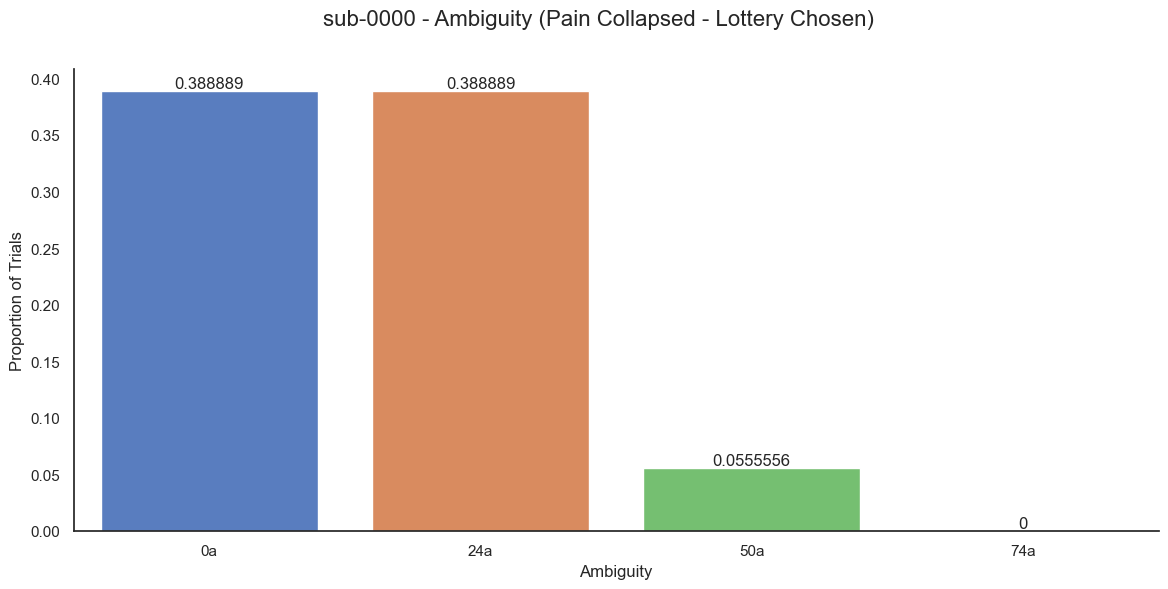

In [10]:
agg_amb_df1 = pd.DataFrame()

for x0 in ["0", "24", "50", "74"]:
    agg_amb_df1["{0}a".format(x0)] = agg_amb_df["{0}a_lott".format(x0)] / (agg_amb_df["{0}a_lott".format(x0)] 
                                                                            + agg_amb_df["{0}a_safe".format(x0)] 
                                                                            + agg_amb_df["{0}a_nr".format(x0)])
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(agg_amb_df1)
ax.set_ylabel("Proportion of Trials")
sns.despine(top=True)
#ax.set_yticklabels(ax.get_yticks().astype(int))
ax.bar_label(ax.containers[0])
ax.set_xlabel("Ambiguity")
plt.suptitle("sub-" + subs[i] + " - Ambiguity (Pain Collapsed - Lottery Chosen)", fontsize=16) 
plt.show()

#### Ambiguity Trials by Pain Level

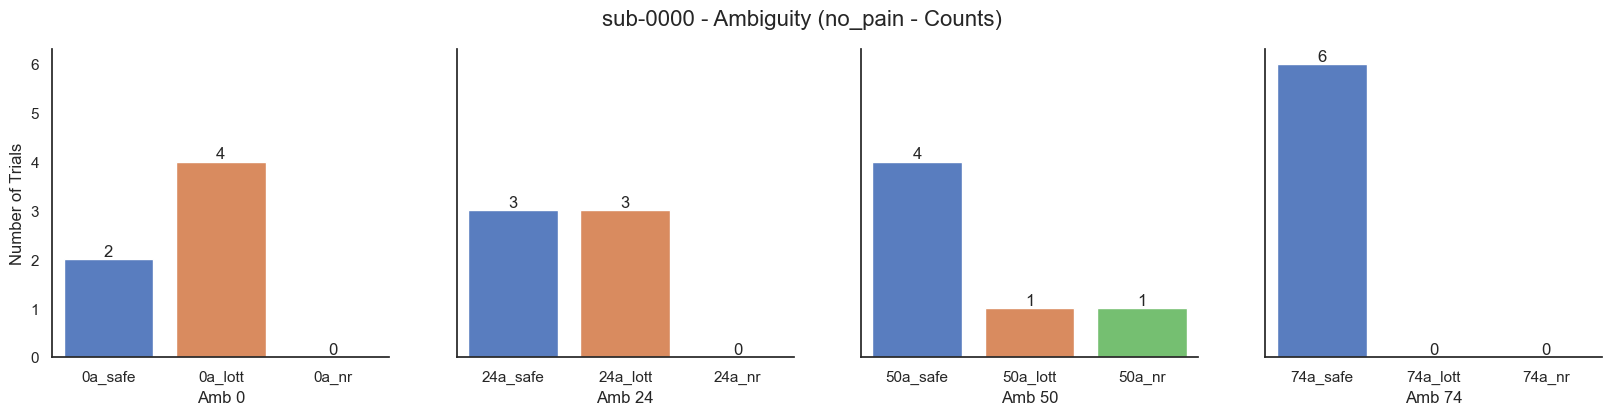

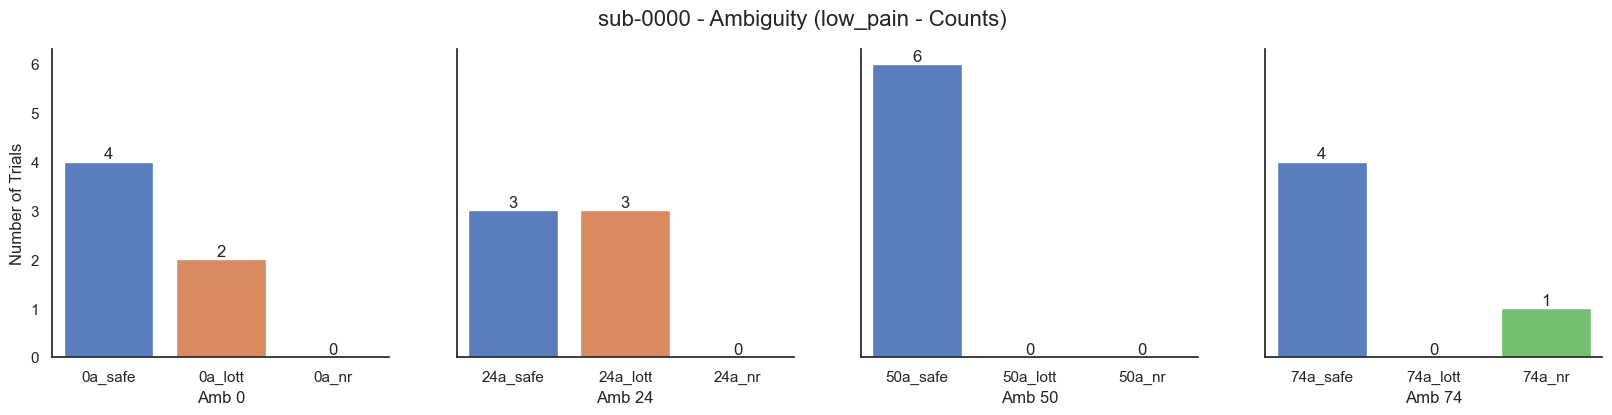

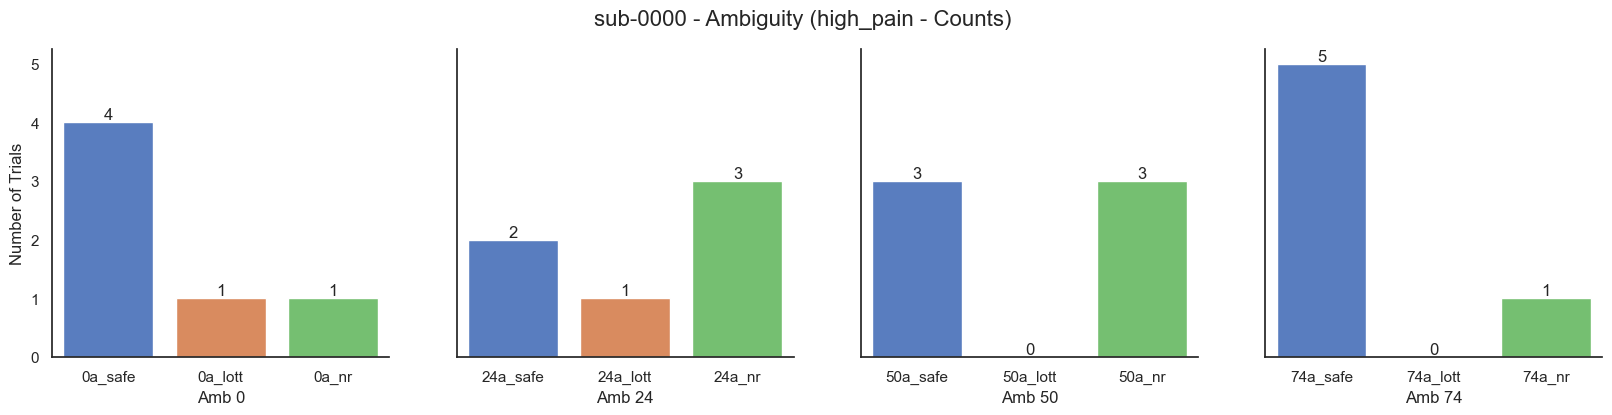

In [11]:
for x2 in ["no_pain", "low_pain", "high_pain"]:
    agg_amb_df2 = pd.DataFrame()
    for x3 in ["0", "24", "50", "74"]:
        for x4 in ["safe", "lott", "nr"]:
            agg_amb_df2["{0}a_{1}".format(x3, x4)] = amb_counts_df["{0}_50p_{1}a_{2}".format(x2, x3, x4)]
    fig, axs = plt.subplots(ncols=4, figsize=(20,4), sharex=False, sharey=True)
    sns.despine(top=True)
    sns.barplot(agg_amb_df2[agg_amb_df2.columns[:3].tolist()], ax=axs[0])
    axs[0].bar_label(axs[0].containers[0])
    axs[0].set_xlabel("Amb 0")
    axs[0].set_ylabel("Number of Trials")
    sns.barplot(agg_amb_df2[agg_amb_df2.columns[3:6].tolist()], ax=axs[1])
    axs[1].bar_label(axs[1].containers[0])
    axs[1].set_xlabel("Amb 24")
    sns.barplot(agg_amb_df2[agg_amb_df2.columns[6:9].tolist()], ax=axs[2])
    axs[2].bar_label(axs[2].containers[0])
    axs[2].set_xlabel("Amb 50")
    sns.barplot(agg_amb_df2[agg_amb_df2.columns[9:12].tolist()], ax=axs[3])
    axs[3].bar_label(axs[3].containers[0])
    axs[3].set_xlabel("Amb 74")
    plt.suptitle("sub-" + subs[i] + " - Ambiguity ({0} - Counts)".format(x2), fontsize=16)  

Text(0.5, 0.98, 'sub-0000 - Ambiguity (Lottery Chosen)')

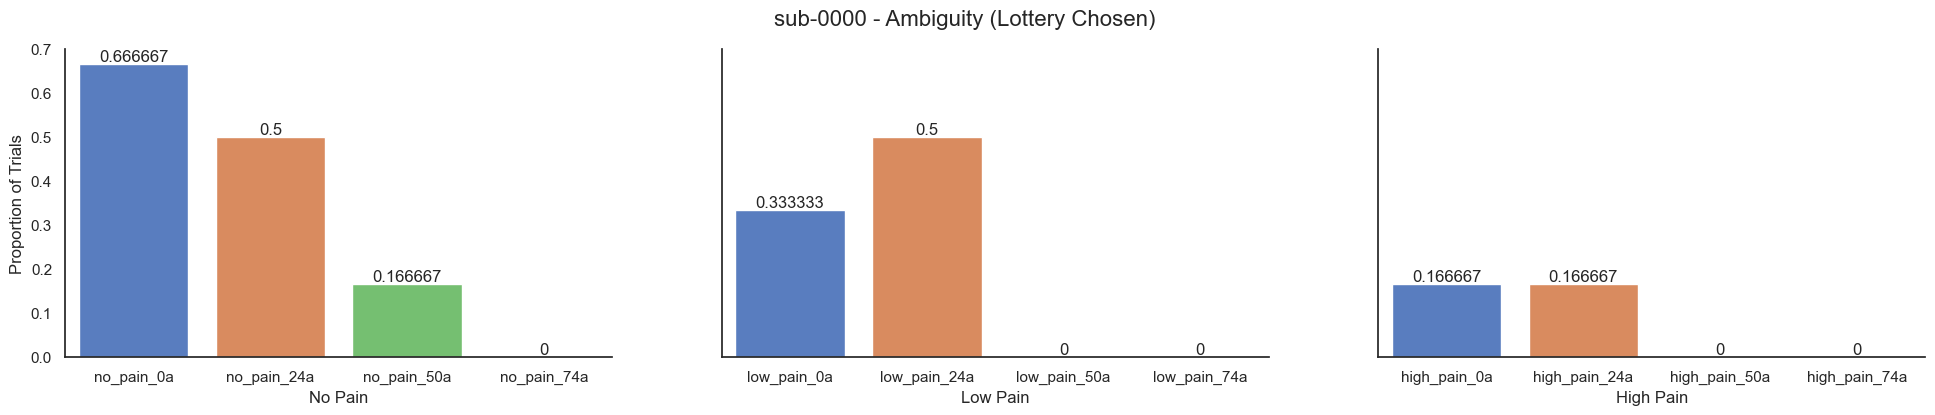

In [12]:
agg_amb_df3 = pd.DataFrame()
for x2 in ["no_pain", "low_pain", "high_pain"]:
    for x3 in ["0", "24", "50", "74"]:
        agg_amb_df3["{0}_{1}a".format(x2, x3)] = amb_counts_df["{0}_50p_{1}a_lott".format(x2, x3)] / (amb_counts_df["{0}_50p_{1}a_lott".format(x2, x3)] 
                                                                                                    + amb_counts_df["{0}_50p_{1}a_safe".format(x2, x3)] 
                                                                                                    + amb_counts_df["{0}_50p_{1}a_nr".format(x2, x3)])
fig, axs = plt.subplots(ncols=3, figsize=(24,4), sharex=False, sharey=True)
sns.despine(top=True)
sns.barplot(agg_amb_df3[agg_amb_df3.columns[:4].tolist()], ax=axs[0])
axs[0].bar_label(axs[0].containers[0])
axs[0].set_xlabel("No Pain")
axs[0].set_ylabel("Proportion of Trials")
sns.barplot(agg_amb_df3[agg_amb_df3.columns[4:8].tolist()], ax=axs[1])
axs[1].bar_label(axs[1].containers[0])
axs[1].set_xlabel("Low Pain")
sns.barplot(agg_amb_df3[agg_amb_df3.columns[8:12].tolist()], ax=axs[2])
axs[2].bar_label(axs[2].containers[0])
axs[2].set_xlabel("High Pain")
plt.suptitle("sub-" + subs[i] + " - Ambiguity (Lottery Chosen)", fontsize=16)  

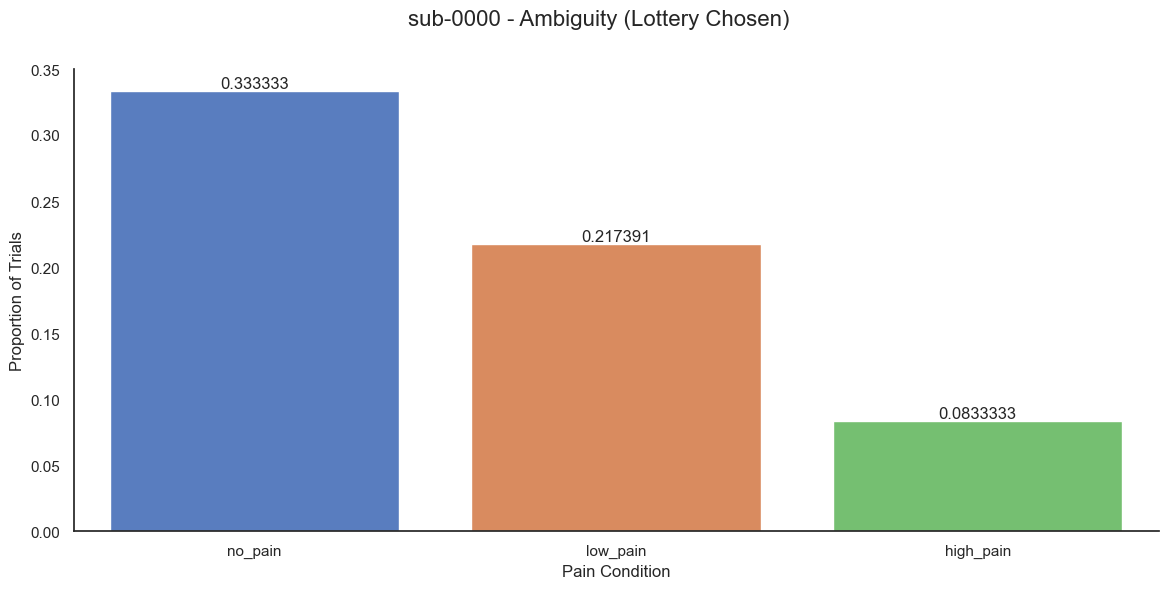

In [13]:
agg_amb_df4 = pd.DataFrame()

for a in ["no_pain", "low_pain", "high_pain"]:
    agg_amb_df4["{0}".format(a)] = (amb_counts_df["{0}_50p_0a_lott".format(a)] + amb_counts_df["{0}_50p_24a_lott".format(a)] + amb_counts_df["{0}_50p_50a_lott".format(a)] 
                                    + amb_counts_df["{0}_50p_74a_lott".format(a)]) / (amb_counts_df["{0}_50p_0a_lott".format(a)] + amb_counts_df["{0}_50p_24a_lott".format(a)] 
                                                                                    + amb_counts_df["{0}_50p_50a_lott".format(a)] + amb_counts_df["{0}_50p_74a_lott".format(a)] 
                                                                                    + amb_counts_df["{0}_50p_0a_safe".format(a)] + amb_counts_df["{0}_50p_24a_safe".format(a)] 
                                                                                    + amb_counts_df["{0}_50p_50a_safe".format(a)] + amb_counts_df["{0}_50p_74a_safe".format(a)] 
                                                                                    + amb_counts_df["{0}_50p_0a_nr".format(a)] + amb_counts_df["{0}_50p_24a_nr".format(a)] 
                                                                                    + amb_counts_df["{0}_50p_50a_nr".format(a)] + amb_counts_df["{0}_50p_74a_nr".format(a)])
fig, ax = plt.subplots(figsize = (14,6))
sns.barplot(agg_amb_df4)
ax.set_ylabel("Proportion of Trials")
sns.despine(top=True)
#ax.set_yticklabels(ax.get_yticks().astype(int))
ax.bar_label(ax.containers[0])
ax.set_xlabel("Pain Condition")
plt.suptitle("sub-" + subs[i] + " - Ambiguity (Lottery Chosen)", fontsize=16) 
plt.show() 

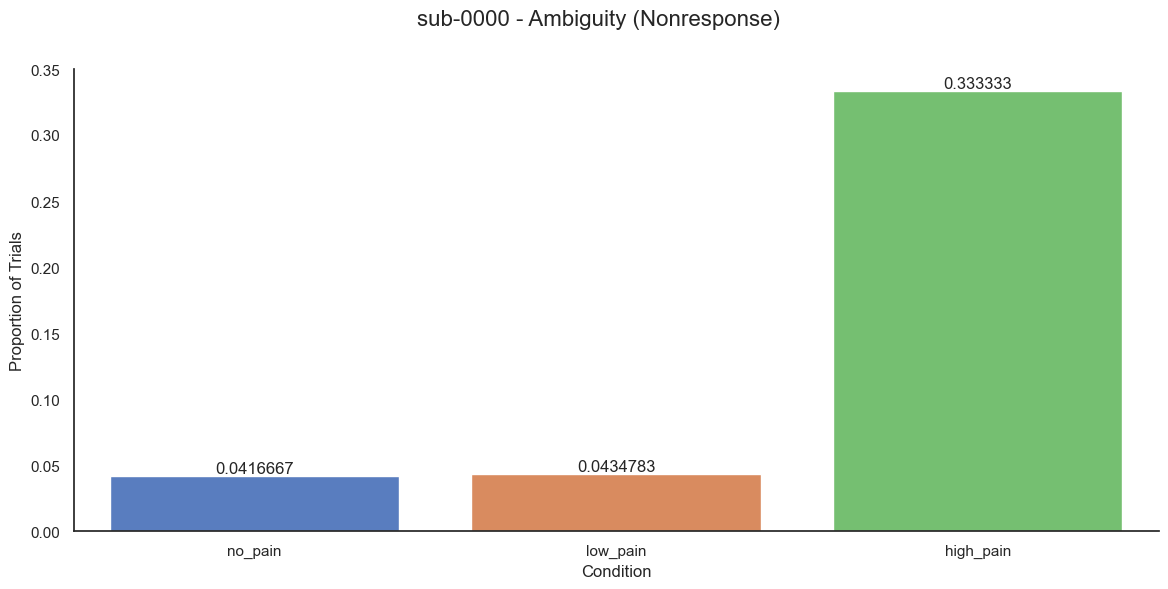

In [14]:
agg_amb_df5 = pd.DataFrame()

for this_pain in ["no_pain", "low_pain", "high_pain"]:
    agg_amb_df5["{0}".format(this_pain)] = (amb_counts_df["{0}_50p_0a_nr".format(this_pain)] + amb_counts_df["{0}_50p_24a_nr".format(this_pain)] + amb_counts_df["{0}_50p_50a_nr".format(this_pain)] 
                                            + amb_counts_df["{0}_50p_74a_nr".format(this_pain)]) / (amb_counts_df["{0}_50p_0a_nr".format(this_pain)] + amb_counts_df["{0}_50p_24a_nr".format(this_pain)] 
                                                                                                    + amb_counts_df["{0}_50p_50a_nr".format(this_pain)] + amb_counts_df["{0}_50p_74a_nr".format(this_pain)]
                                                                                                    + amb_counts_df["{0}_50p_0a_safe".format(this_pain)] + amb_counts_df["{0}_50p_24a_safe".format(this_pain)] 
                                                                                                    + amb_counts_df["{0}_50p_50a_safe".format(this_pain)] + amb_counts_df["{0}_50p_74a_safe".format(this_pain)]
                                                                                                    + amb_counts_df["{0}_50p_0a_lott".format(this_pain)] + amb_counts_df["{0}_50p_24a_lott".format(this_pain)] 
                                                                                                    + amb_counts_df["{0}_50p_50a_lott".format(this_pain)] + amb_counts_df["{0}_50p_74a_lott".format(this_pain)])
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(agg_amb_df5)
ax.set_ylabel("Proportion of Trials")
sns.despine(top=True)
#ax.set_yticklabels(ax.get_yticks().astype(int))
ax.bar_label(ax.containers[0])
ax.set_xlabel("Condition")
plt.suptitle("sub-" + subs[i] + " - Ambiguity (Nonresponse)", fontsize=16) 
plt.show()

## Pain Ratings Across All Trials

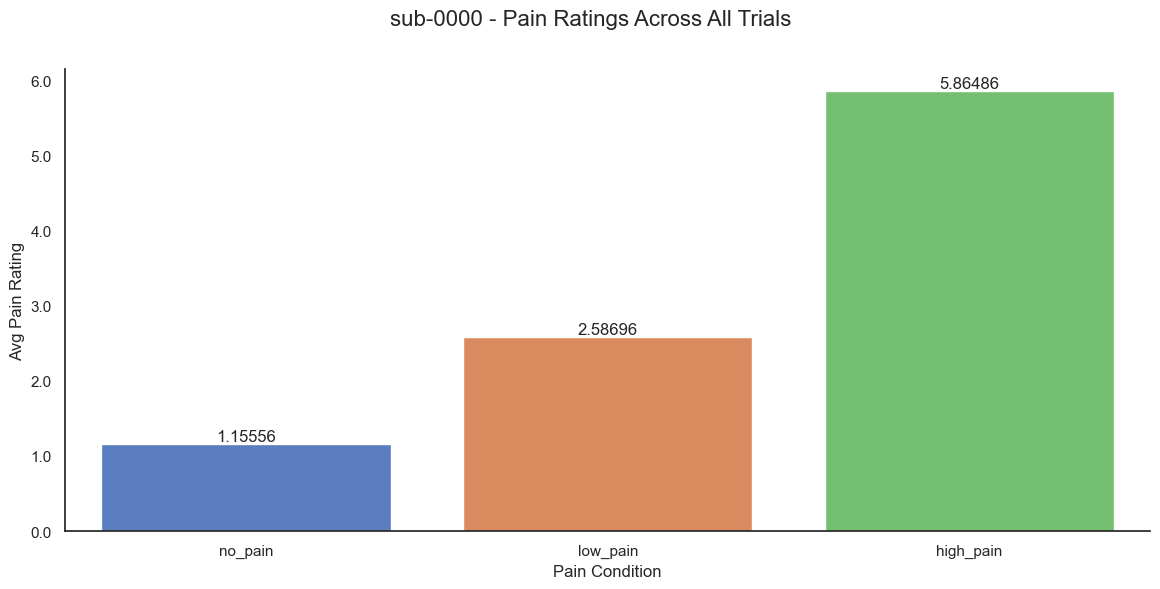

In [15]:
conditions = {}
ratings = {}

for idx, sub in enumerate(subs):
    sub_file = glob(os.path.join(base_proj_dir, "derivatives/ev/sub-{0}/crdm/sub-{0}_ses-crdm_ev.csv".format(subs[i])))[0]
    qc_df = pd.read_csv(sub_file)
    for idx2, this_cond in enumerate(["no_pain", "low_pain", "high_pain"]):
        conditions["{0}".format(this_cond)] = qc_df.loc[(qc_df['choice'].notnull()) & (qc_df['pain'] == idx2)]
        ratings["{0}".format(this_cond)] = np.mean(conditions["{0}".format(this_cond)]["pain_rating"])
ratings_df = pd.DataFrame(ratings, index = subs)
fig, ax = plt.subplots(figsize = (14,6))
sns.barplot(ratings_df)
ax.set_ylabel("Avg Pain Rating")
sns.despine(top=True)
ax.set_yticklabels(ax.get_yticks().astype(float))
ax.bar_label(ax.containers[0])
ax.set_xlabel("Pain Condition")
plt.suptitle("sub-" + subs[i] + " - Pain Ratings Across All Trials", fontsize=16) 
plt.show() 